In [2]:
!pip install imutils

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=c724a2bef336439a6239932a627c1616b648d58ce6a240b5ac8bf38087fa518c
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    shear_range = 0.2, 
    zoom_range = 0.2,
    validation_split = 0.25
)

data_path='../input/calculator/All data (Compressed)'
train_set = train_datagen.flow_from_directory(
    data_path, 
    target_size = (40, 40), 
    color_mode = 'grayscale',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    subset='training',
    seed = 123
)
valid_set = train_datagen.flow_from_directory(
    data_path, 
    target_size = (40, 40), 
    color_mode = 'grayscale',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    subset='validation',
    seed = 123
)

Found 250428 images belonging to 16 classes.
Found 83467 images belonging to 16 classes.


In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='softmax'))
adam = tf.keras.optimizers.Adam(lr = 5e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
model.fit(train_set,validation_data=valid_set,epochs=3, verbose=1)

Epoch 1/3
7826/7826 [==============================] - 2830s 361ms/step - loss: 0.6528 - accuracy: 0.7953 - val_loss: 0.3584 - val_accuracy: 0.8895
Epoch 2/3
7826/7826 [==============================] - 604s 77ms/step - loss: 0.2117 - accuracy: 0.9309 - val_loss: 0.2702 - val_accuracy: 0.9179
Epoch 3/3
7826/7826 [==============================] - 610s 78ms/step - loss: 0.1523 - accuracy: 0.9495 - val_loss: 0.2239 - val_accuracy: 0.9307


In [7]:
val_loss, val_accuracy = model.evaluate(valid_set)
print(val_loss,val_accuracy)

2609/2609 [==============================] - 89s 34ms/step - loss: 0.2271 - accuracy: 0.9298
0.22705742716789246 0.9298166036605835


In [21]:
def prediction(img):
    plt.imshow(img, cmap = 'gray')
    img = cv2.resize(img,(40, 40))
    norm_image = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.reshape((norm_image.shape[0], norm_image.shape[1], 1))
    case = np.asarray([norm_image])
    pred = model.predict_classes([case])
    print(pred)
    
    return ([i for i in train_set.class_indices if train_set.class_indices[i]==(pred[0])][0],pred)

In [22]:
train_set.class_indices

{'%': 0,
 '*': 1,
 '+': 2,
 '-': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 '[': 14,
 ']': 15}

In [23]:
label_map = (train_set.class_indices)
label_map

{'%': 0,
 '*': 1,
 '+': 2,
 '-': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 '[': 14,
 ']': 15}

[7]
[1]
[6]


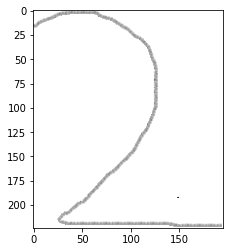

In [92]:
image = cv2.imread('../input/testing1/3.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
chars=[]
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if w*h>1200:
        roi = gray[y:y + h, x:x + w]
        chars.append(prediction(roi))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

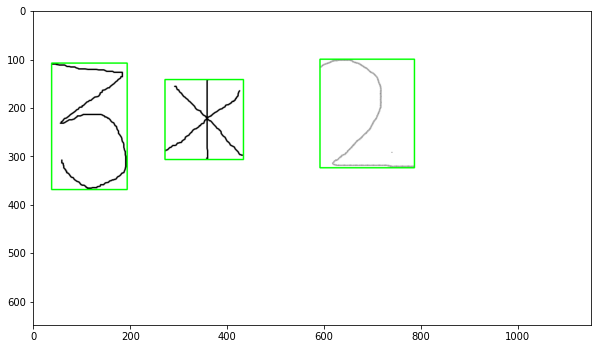

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(image)

In [94]:
chars

[('3', array([7])), ('*', array([1])), ('2', array([6]))]

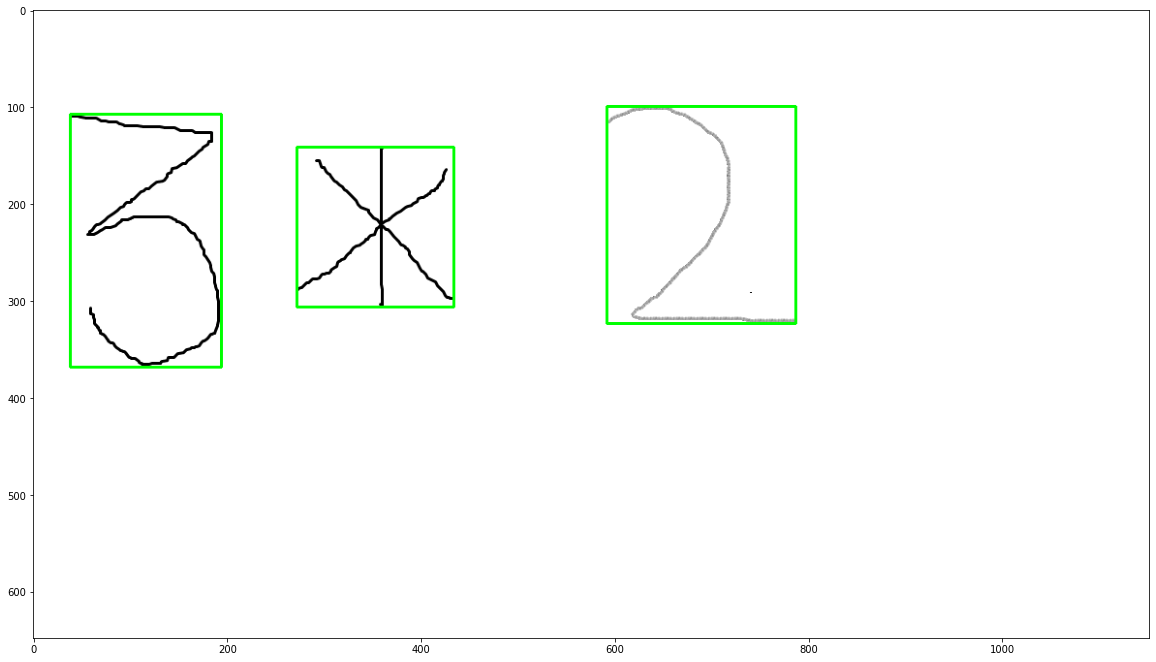

In [95]:
plt.figure(figsize=(20,20))
plt.imshow(image)

In [96]:
labels=[i for i in train_set.class_indices]
print(labels)

['%', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', ']']


In [97]:
eq=[]
pos=[]
for i in ((chars)):
    if len(eq)==0 and i[0][0] in labels[3:]:
        eq.append(i[0][0])
    elif len(eq)>0 and i[0][0] in labels[4:14]:
        eq.append(i[0][0])
    elif len(eq)>0 and i[0][0] in labels[:4]:
        eq.append(i[0][0])
        pos.append(len(eq))
    else:
        pass

In [98]:
for i in pos:
    if eq[i-1]=='+':
        print(int(''.join(eq[:pos[0]-1]))+int(''.join(eq[pos[0]:])))
    elif eq[i-1]=='%': 
        print(int(''.join(eq[:pos[0]-1]))/int(''.join(eq[pos[0]:])))
    elif eq[i-1]=='*':
        print(int(''.join(eq[:pos[0]-1]))*int(''.join(eq[pos[0]:])))
    else:
        print(int(''.join(eq[:pos[0]-1]))-int(''.join(eq[pos[0]:])))

6
